# Data analysis for the paper: Autonomous Platform for Solution Processing of Electronic Polymers

## Install and import required packages

In [ ]:
!pip install shap
!pip install umap-learn
!pip install cmasher
!pip install scikit-learn
!pip install plotly

In [11]:
import itertools
import pickle
import re
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import shap
import sklearn
import umap
from matplotlib.collections import LineCollection
from matplotlib.path import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
import cmasher as cmr
%matplotlib inline

## Import experimental data

In [ ]:
pedot_data = pd.read_csv('PEDOT_experiment.csv')
pedot_data

In [4]:
pedot_training_data = pedot_data[pedot_data['Dataset'] == 'Train']
pedot_test_data = pedot_data[pedot_data['Dataset'] == 'Test']

pedot_param_keys = [
    'DMSO concentration (Vol%)',
    'EG concentration (Vol%)',
    'Coating speed (mm/sec)',
    'Coating temperature (Celsius)',
    'Post-processing solvent No.',
    'Post coating speed (mm/sec)',
    'Post coating temperature (Celsius)',
]

pedot_output_keys = [
        "Average coverage (%)",
        "Average conductivity (S/cm)",
]

In [5]:
large_film_data = pd.read_excel('large_printed_film_conductivity.xlsx', header=None)
large_film_data

,0,1
0,1,4098.36066
1,2,3636.36364
2,3,4901.96078
3,4,5291.00529
4,5,5263.15789
5,6,4201.68067


## Data distribution: Figure 3 a & c

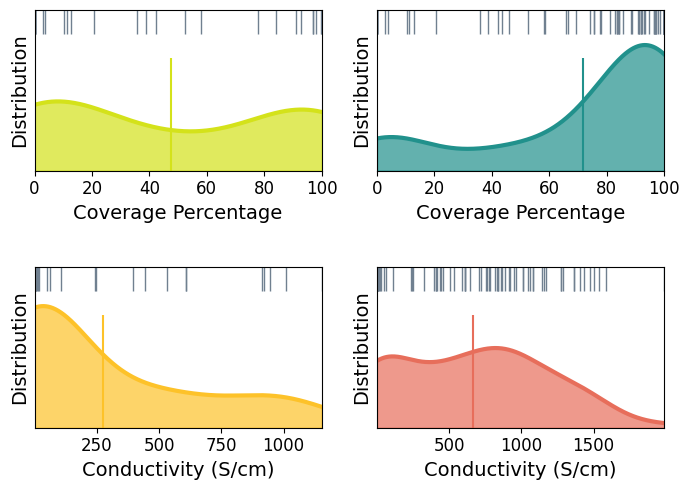

In [6]:
def kde_scipy(x, y, bw=None):
    try:
        bw /= np.std(y, ddof=1)
    except:
        pass
    kde = gaussian_kde(y, bw_method=bw)
    # print("kde_scipy bw =", kde.covariance_factor() * np.std(y, ddof=1))
    return kde.evaluate(x)


def add_rugplot(data, height=0.05, ax=None, location='bottom', **kwargs):
    ax = ax or plt.gca()
    y = {
        'top': (np.ones_like(data), np.ones_like(data) - height),
        'bottom': (np.zeros_like(data), np.zeros_like(data) + height),
    }[location]
    bars = np.stack((np.c_[data, data], np.c_[y]), axis=-1)
    lc = LineCollection(bars, transform=ax.get_xaxis_transform(), **kwargs)
    ax.add_collection(lc)


fig, axs = plt.subplots(2, 2, figsize=(7, 5))

for row, k in enumerate(pedot_output_keys):
    for col, typ in enumerate(["Train", "All"]):
        ax = axs[row, col]

        y = {
            "Train": pedot_training_data[k],
            "Test": pedot_test_data[k],
            "All": pedot_data[k],
        }[typ]
        x = np.linspace(y.min(), y.max(), 1000)

        color = {
            "Average conductivity (S/cm)_Train": '#fdc229',
            "Average conductivity (S/cm)_All": '#e76e5b',
            "Average coverage (%)_Train": '#d4e21a',
            "Average coverage (%)_All": '#21918c',
        }[f"{k}_{typ}"]

        # print('\n',k,typ,np.mean(y), np.max(y))
        density = kde_scipy(x, y)
        norm_density = density / density.sum()
        ax.plot(x, norm_density, lw=3, c=color)
        add_rugplot(y, ax=ax, height=0.15, lw=1, location='top', color='slategray')
        ax.set_yticks([])
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.vlines([np.mean(y)], 0, 0.7, color=color, transform = ax.get_xaxis_transform())

        if k.startswith('conduct'):
            ax.set_xlim(xmin=0, xmax=2000)
        else:
            ax.set_xlim(xmin=x.min(), xmax=x.max())
        ax.set_ylim(ymin=-1e-5*0, ymax=3e-3)

        ax.fill_between(x, ax.get_ylim()[0], norm_density, alpha=0.7, color=color)

        ax.set_xlabel({
            "Average conductivity (S/cm)": "Conductivity (S/cm)",
            "Average coverage (%)": "Coverage Percentage",
        }[k], fontsize=14)
        ax.set_ylabel("Distribution", fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.6)
# plt.savefig(f"dist_all.png")

## UMAP projection: Figure 3 d & e

In [7]:
all_design_space = [
    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    [60, 65, 70, 75, 80, 85, 90, 95, 100],
    [1, 2, 3, 4, 5, 6, 7, 8],
    [0.5, 1.0, 1.5, 2.0],
    [60, 65, 70, 75, 80, 85, 90, 95, 100],
]
lookup_list = list(itertools.product(*all_design_space))
lookup_init = pd.DataFrame(lookup_list, columns=pedot_param_keys)
lookup_init

,DMSO concentration (Vol%),EG concentration (Vol%),Coating speed (mm/sec),Coating temperature (Celsius),Post-processing solvent No.,Post coating speed (mm/sec),Post coating temperature (Celsius)
0,0.0,0.0,0.5,60,1,0.5,60
1,0.0,0.0,0.5,60,1,0.5,65
2,0.0,0.0,0.5,60,1,0.5,70
3,0.0,0.0,0.5,60,1,0.5,75
4,0.0,0.0,0.5,60,1,0.5,80
...,...,...,...,...,...,...,...
933115,5.0,5.0,5.0,100,8,2.0,80
933116,5.0,5.0,5.0,100,8,2.0,85
933117,5.0,5.0,5.0,100,8,2.0,90
933118,5.0,5.0,5.0,100,8,2.0,95


In [8]:
pedot_params = pedot_data[pedot_param_keys]
pedot_params_exp = [
    list(set(pedot_params[i].values)) for i in pedot_param_keys
]
lookup_list = list(itertools.product(*pedot_params_exp))
lookup_init = pd.DataFrame(lookup_list, columns=pedot_param_keys)

# Scalling the datasets
scaler = MinMaxScaler()
whole_space_scaled = scaler.fit_transform(lookup_init.values)
experimenal_space_scaled = scaler.transform(pedot_params.values)

In [9]:
# UMAP projection

reducer = umap.UMAP(n_neighbors=5, min_dist=0.01, random_state=1)  # 6

embedding = reducer.fit_transform(whole_space_scaled)
embedding_exp = reducer.transform(experimenal_space_scaled)

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


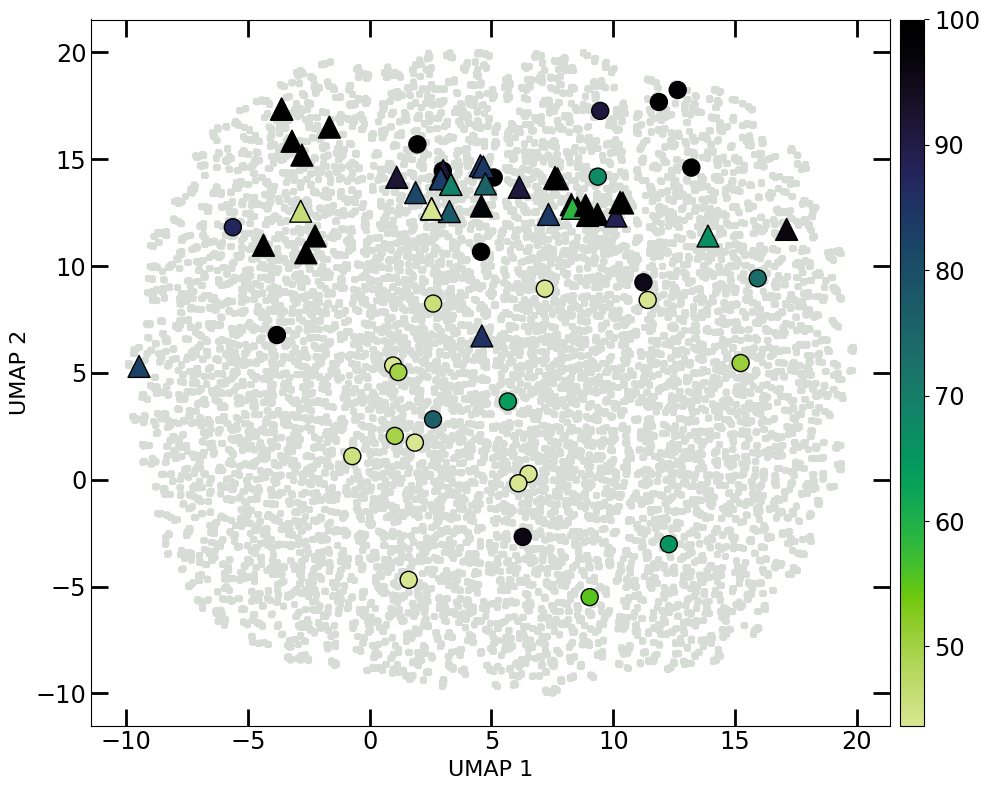

In [14]:
# UMAP of coverage

plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False


fig, ax = plt.subplots(figsize=(10, 8))
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# ax.axis(aspect='equal')
ax.set(adjustable='box')  # , aspect='equal')
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.axis('on')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis='both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='both', which='major', length=12)
ax.tick_params(axis='both', which='minor', length=8, color='black')
ax.tick_params(
    axis='both',
    which='both',
    bottom=True,
    top=True,
    left=True,
    right=True,
    direction='in',
)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    color='#d8dcd6',
    alpha=0.002,
    s=20,
    edgecolor="#d8dcd6",
    label='Overal experimental space',
)

plt.scatter(
    embedding_exp[:30, 0],
    embedding_exp[:30, 1],
    c=[pedot_data['Average coverage (%)'][:30]],
    cmap='cmr.toxic_r',
    marker='o',
    edgecolor="black",
    s=150,
    label='Experimental space explored so far (train)',
)

plt.scatter(
    embedding_exp[30:, 0],
    embedding_exp[30:, 1],
    c=[pedot_data['Average coverage (%)'][30:]],
    cmap='cmr.toxic_r',
    marker='^',
    edgecolor="black",
    s=250,
    label='Experimental space explored so far (test)',
)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

clb = plt.colorbar(orientation='vertical', cax=cax)
# plt.xlabel('UMAP 1')
ax.set_xlabel('UMAP 1', fontsize=16)
ax.set_ylabel('UMAP 2', fontsize=16)
plt.tight_layout()
# plt.savefig('umap_coverage.png', dpi=600)

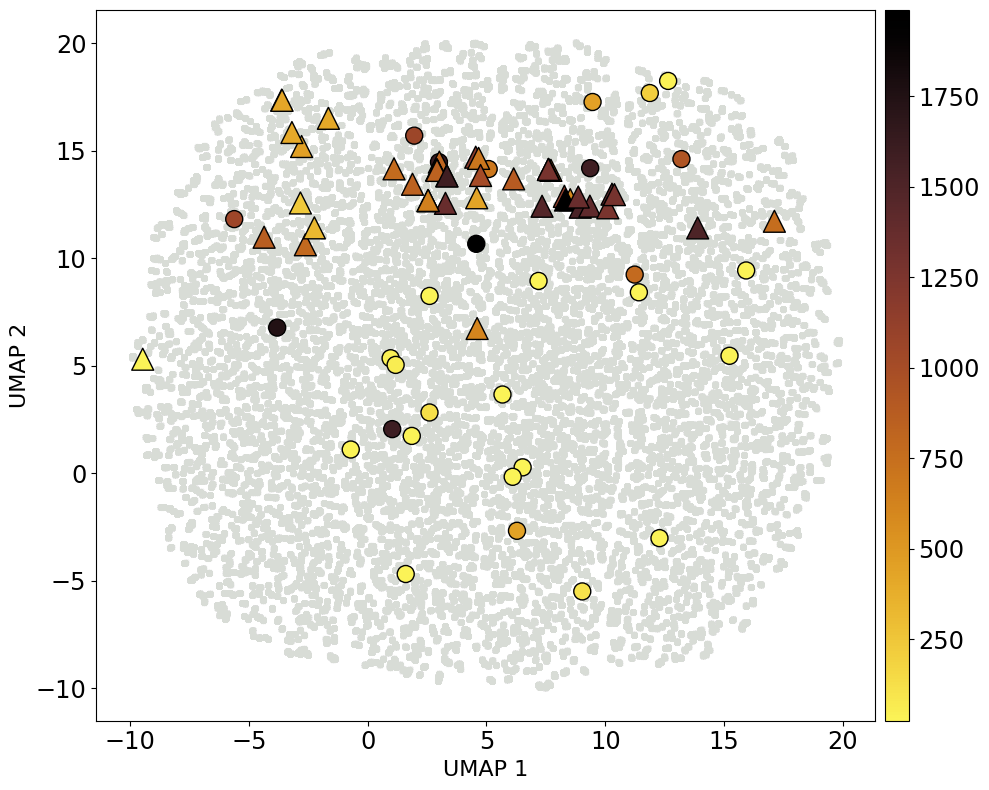

In [24]:
# UMAP of concuctivity
fig, ax = plt.subplots(figsize=(10, 8))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    color='#d8dcd6',
    alpha=0.002,
    s=20,
    edgecolor="#d8dcd6",
    label='Overal experimental space',
)

plt.scatter(
    embedding_exp[:30, 0],
    embedding_exp[:30, 1],
    c=[pedot_data['Average conductivity (S/cm)'][:30]],
    cmap='cmr.amber_r',
    marker='o',
    edgecolor="black",
    s=150,
    label='Experimental space explored so far (train)',
)

plt.scatter(
    embedding_exp[30:, 0],
    embedding_exp[30:, 1],
    c=[pedot_data['Average conductivity (S/cm)'][30:]],
    cmap='cmr.amber_r',
    marker='^',
    edgecolor="black",
    s=250,
    label='Experimental space explored so far (test)',
)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

clb = plt.colorbar(orientation='vertical', cax=cax)
# plt.xlabel('UMAP 1')
ax.set_xlabel('UMAP 1', fontsize=16)
ax.set_ylabel('UMAP 2', fontsize=16)
plt.tight_layout()
# plt.savefig('umap_conduct.png', dpi=600)

## Figure 3f - Barchart of conductivities

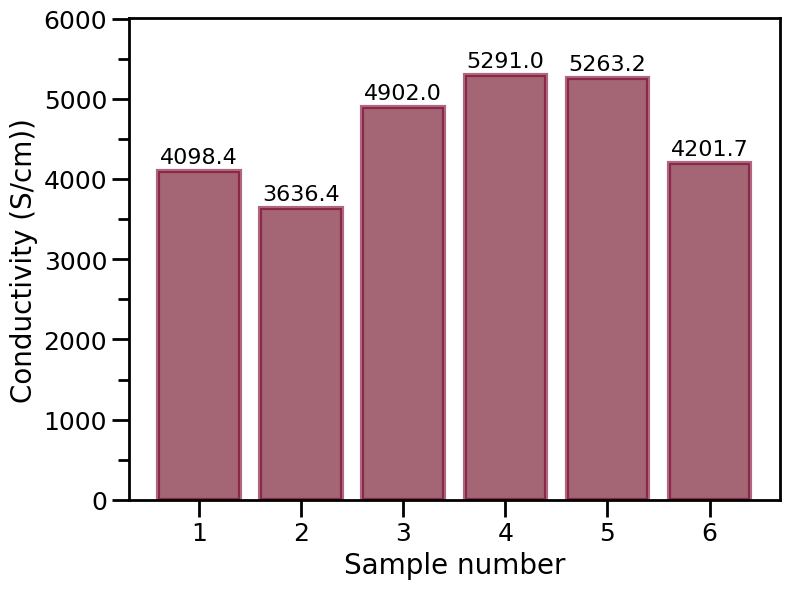

In [29]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set(adjustable='box')
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.axis('on')


major_ticks_y = np.arange(0, 6002, 1000)
minor_ticks_y = np.arange(0, 6002, 500)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

ax.tick_params(axis='both', which='both', width=2)
# ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='both', which='major', length=12, labelsize=18)
ax.tick_params(axis='both', which='minor', length=8, color='black')

bars = ax.bar(
    x=np.arange(large_film_data.shape[0]),
    height=large_film_data.iloc[:, 1],
    tick_label=[1, 2, 3, 4, 5, 6],
    facecolor='#680018',
    edgecolor='#7b002c',
    linewidth=3,
    alpha=0.6,
)  # 6e1005

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 100,
        round(bar.get_height(), 1),
        horizontalalignment='center',
        color='black',
        weight='normal',
        fontsize=16,
    )

ax.set_xlabel('Sample number', fontsize=20, color='black')
ax.set_ylabel('Conductivity (S/cm))', fontsize=20, color='black')
ax.set_ylim(0, 6001)

fig.tight_layout()
# plt.savefig('conduct_large.png', dpi=600)

## Parallel coordinates plot: Figure 4a

In [30]:
ynames = [
    'DMSO V%',
    'EG V%',
    'Coating\n velocity',
    'Coating\n temperature',
    'Post-processing\n solvents',
    'Post-processing\n velocity',
    'Post-processing\n temperature',
    'Coverage',
    'Conductivity',
]

dataset = pd.DataFrame(
    pedot_data[pedot_param_keys + pedot_output_keys].values,
    columns=ynames,
)

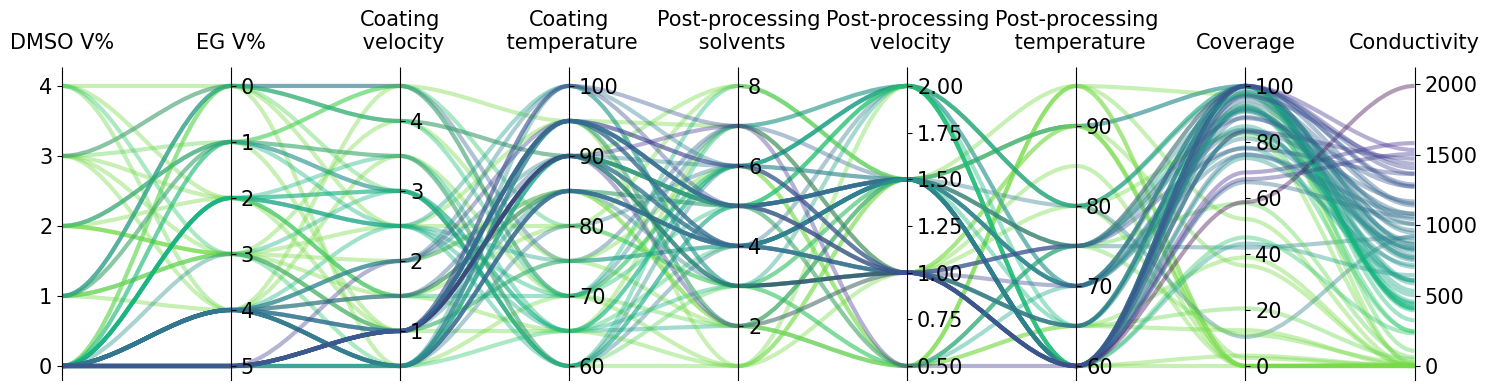

In [31]:
# Create the parallel coordinates plot

pedot_data['norm'] = MinMaxScaler().fit_transform(
    np.array(pedot_data['Average conductivity (S/cm)'].values.reshape(-1, 1))
)

ys = dataset.values
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05
ymaxs += dys * 0.05

ymaxs[1], ymins[1] = ymins[1], ymaxs[1]
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(15, 4))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')

        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=15)
host.tick_params(axis='x', which='major', pad=10)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()

colors = plt.get_cmap('cmr.lavender_r').colors
colo = np.round(pedot_data.norm * 200).astype('int').values

for j in range(ys.shape[0]):
    # create bezier curves
    verts = list(
        zip(
            [
                x
                for x in np.linspace(
                    0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True
                )
            ],
            np.repeat(zs[j, :], 3)[1:-1],
        )
    )
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(
        path, facecolor='none', lw=3, alpha=0.4, edgecolor=colors[colo[j]]
    )
    host.add_patch(patch)

plt.tight_layout()
# plt.savefig('parallel coordinates_actual.svg', dpi=600)
plt.show()

## Loading plots : Figure 4b

In [89]:
# Scalling the datasets

pedot_params = pedot_data[pedot_param_keys + pedot_output_keys]
scaler = StandardScaler()
experimenal_space_scaled = scaler.fit_transform(pedot_params.values)
experimenal_space_scaled = pd.DataFrame(experimenal_space_scaled, columns=pedot_params.columns)
conduct_responce = experimenal_space_scaled['Average conductivity (S/cm)']
coverage_responce = experimenal_space_scaled['Average coverage (%)']

X, Y = experimenal_space_scaled.iloc[:, :], pd.concat(
    [conduct_responce, coverage_responce], axis=1
)
cca = CCA(n_components=Y.shape[1])

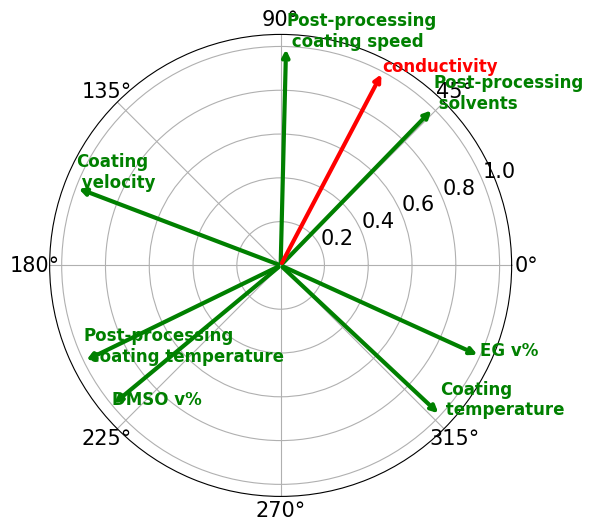

In [90]:
cca = CCA(n_components=Y.shape[1])
cca.fit(X, Y)

# rotation matrices
xrot = cca.x_loadings_  # loadings
yrot = cca.y_loadings_  # loadings
rot = np.vstack((xrot, yrot))

X_cols = [
    'DMSO v%',
    'EG v%',
    'Coating\n velocity',
    'Coating\n temperature',
    'Post-processing\n solvents',
    'Post-processing\n coating speed',
    'Post-processing\n coating temperature',
]
Y_cols = ['conductivity']

def cart2pol(x, y):
    # rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (1, phi)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
for i, col in enumerate(X_cols + Y_cols):
    x = rot[i, 0]
    y = rot[i, 1]

    rho, phi = cart2pol(x, y)
    plt.plot(phi, rho)
    # arrow and a text label
    color = 'r' if col in Y_cols else 'green'
    plt.annotate(
        "",
        xy=(phi, rho),
        xytext=(0, 0),
        arrowprops=dict(arrowstyle="->", color=color, lw=3),
    )

    plt.text(phi, rho, col, color=color, fontsize=12, fontweight='bold')
plt.show()
# plt.savefig('cca_conductivity_surface_all.png')

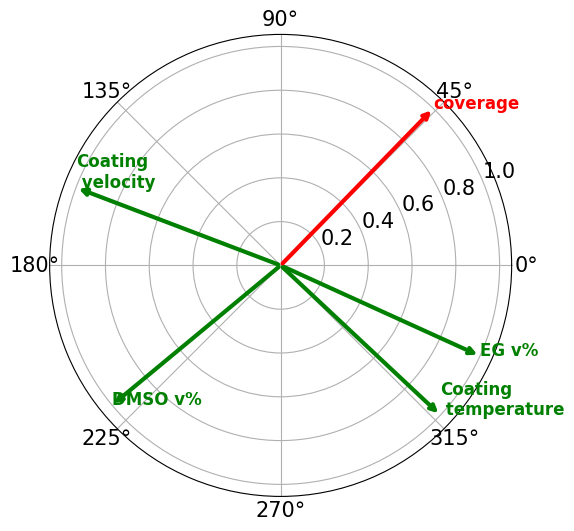

In [92]:
import pandas as pd
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import numpy as np

# Create and fit the CCA model
cca = CCA(n_components=Y.shape[1])
cca.fit(X, Y)

# rotation matrices
xrot = cca.x_loadings_  # loadings
yrot = cca.y_loadings_  # loadings
rot = np.vstack((xrot, yrot))

X_cols = ['DMSO v%',
          'EG v%',
          'Coating\n velocity',
          'Coating\n temperature'
          ]
Y_cols = ['coverage']

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
for i, col in enumerate(X_cols + Y_cols):
    x = rot[i, 0]
    y = rot[i, 1]

    rho, phi = cart2pol(x, y)
    plt.plot(phi, rho)
    # arrow and a text label
    color = 'r' if col in Y_cols else 'green'
    plt.annotate(
        "",
        xy=(phi, rho),
        xytext=(0, 0),
        arrowprops=dict(arrowstyle="->", color=color, lw=3),
    )

    plt.text(phi, rho, col, color=color, fontsize=12, fontweight='bold')
# plt.show()
# plt.savefig('cca_coverage_surface_train.svg')

## trendline: Supporting Information Figure S5

In [50]:
def style_plot(fig):
    fig.update_traces(marker={'size': 7})
    fig.update_layout(plot_bgcolor='white')
    fig.update_layout(
        legend={
            'orientation': 'h',
            'yanchor': "bottom",
            'y': 1.02,
            'xanchor': "left",
            'x': 0,
        }
    )
    fig.update_layout(legend_title_text='')
    axis_setup = {
        'title_font': {'size': 18},
        'mirror': True,
        'ticks': 'outside',
        'showline': True,
        'linecolor': 'grey',
        'gridcolor': 'lightgrey',
        'zeroline': False,
    }
    fig.update_xaxes(**axis_setup)
    fig.update_yaxes(**axis_setup)
    return fig

74
plot file: oect_rf_optimizer_2nd_d2_s80.png


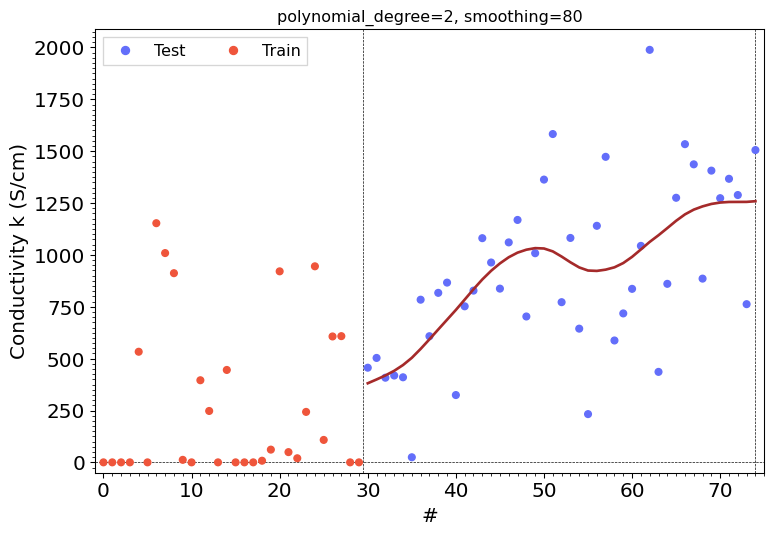

In [51]:
# ---------------------------------------------------------

Ntrain = pedot_training_data.shape[0]
Ngpr = pedot_test_data.shape[0]

color_by = 'Dataset'  # 'coating_on_top.sol_label'
colors = ['#636efa', '#ef553b', '#00cc96', '#059aca', 'green', 'purple']

deg = 2
smooth = 80

# ---------------------------------------------------------


def natsort(s, _reg=re.compile('([0-9]+)')):
    return [
        int(text) if text.isdigit() else text.lower() for text in _reg.split(s)
    ]


def non_monotonic_fit(y_grid, dd=3, smooth=100):
    N = y_grid.size
    E = np.eye(N)
    D3 = np.diff(E, n=dd, axis=0)
    z = np.linalg.solve(E + smooth * D3.T @ D3, y_grid)
    return z


x = pedot_data['index'].values
y = pedot_data['Average conductivity (S/cm)'].values

# plot canvas
fig = plt.figure(figsize=(9, 6), dpi=96)
gs = mpl.gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])
plt.title(f'polynomial_degree={deg}, smoothing={smooth}')

# color map
sub_labels = sorted(pedot_data[color_by].unique(), key=natsort)
cs_map = {s: i for i, s in enumerate(sub_labels)}

# data points
cs = [cs_map[s] for s in pedot_data[color_by]]
scatter = ax.scatter(
    x,
    y,
    linestyle='None',
    c=cs,
    cmap=mpl.colors.ListedColormap(colors[: len(cs_map)]),
    s=25.5,
    label=sub_labels,
    zorder=11,
)

# the regions
args = {'lw': 0.5, 'color': 'k', 'linestyle': '--'}
ax.axvline(x=Ntrain - 1 + 0.5, **args)
print(Ntrain - 1 + Ngpr)
ax.axvline(x=Ntrain - 1 + Ngpr, **args)

# trendline
trend = np.zeros(len(y))
trend[Ntrain:] = non_monotonic_fit(y[Ntrain:], dd=deg, smooth=smooth)
# trend[:Ntrain] = np.median(y[:Ntrain])
ax.plot(
    np.arange(trend.size)[Ntrain:],
    trend[Ntrain:],
    color='brown',
    label='reality trendline',
    lw=2,
    zorder=30,
)

# axes
mpl.rc('xtick', labelsize=15, direction='in')
mpl.rc('ytick', labelsize=15, direction='in')
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.axhline(y=0, linewidth=0.5, color='k', linestyle='--')
ax.set_xlim(xmin=-1, xmax=np.ceil(x[-1]) + 1)
ax.set_ylim(ymin=-50, ymax=None)
ax.set_xlabel("#", size=15)
ax.set_ylabel("Conductivity k (S/cm)", size=15)

# legend
mpl.rc('legend', fontsize=12, fancybox=False, shadow=False)
handles, labels = scatter.legend_elements(prop='colors')
ix = np.argsort(np.array(labels))
handles = [handles[i] for i in ix]
labels = [sub_labels[i] for i in ix]
ax.legend(handles, labels, loc='upper left', facecolor='white', ncol=3)

# label font size
font = mpl.font_manager.FontProperties
myfont = font(size=15)
for s in ax.get_xticklabels() + ax.get_yticklabels():
    s.set_fontproperties(myfont)

# output
ofname = f'oect_rf_optimizer_2nd_d{deg}_s{smooth}.png'
print(f'plot file: {ofname}')
plt.savefig(ofname)
plt.show()

## Pareto front : Supporting Information Figure S6

In [80]:
# Code for calculating the Pareto frontier

def pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    p_front = [myList[0]]
    for pair in myList[1:]:
        if maxY:
            if pair[1] >= p_front[-1][1]:
                p_front.append(pair)
        else:
            if pair[1] <= p_front[-1][1]:
                p_front.append(pair)
    # Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    del p_frontX[1]
    p_frontY = [pair[1] for pair in p_front]
    del p_frontY[1]
    return p_frontX, p_frontY

([1988.672558, 1533.952004, 1406.392079, 1367.019203, 1288.767083, 1275.49728, 860.6480838, 456.3456177, 418.6219859, 410.1386837, 408.0893519, 324.517259], [58.555, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, -20.0, '−20'),
  Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120')])

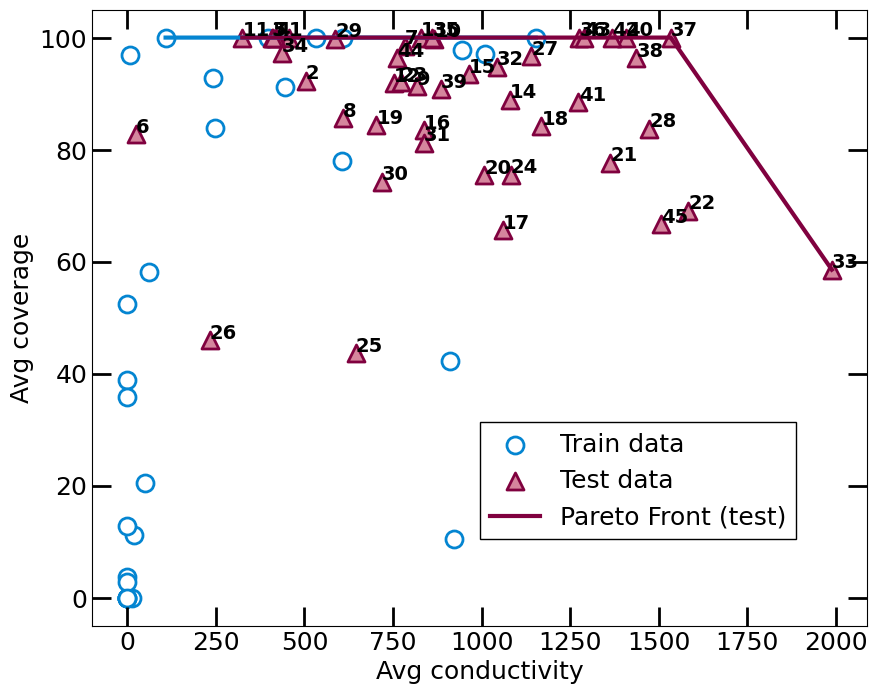

In [81]:
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)  # , aspect='equal')
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis='both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='both', which='major', length=14)
ax.tick_params(
    axis='both', which='minor', length=8, color='black', labelsize=18
)
ax.tick_params(
    axis='both',
    which='both',
    bottom=True,
    top=True,
    left=True,
    right=True,
    direction='in',
)
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')

Xs_train, Ys_train = (
    pedot_data['Average conductivity (S/cm)'][:30],
    pedot_data['Average coverage (%)'][:30],
)
p_front_train = pareto_frontier(Xs_train, Ys_train, maxX=True, maxY=True)
plt.scatter(
    Xs_train,
    Ys_train,
    s=150,
    label='Train data',
    edgecolor='#0485d1',
    facecolor='white',
    linewidths=2,
)
plt.plot(
    p_front_train[0],
    p_front_train[1],
    #label='Pareto front (train)',
    linewidth=3,
    color='#0485d1',
)

Xs, Ys = (
    pedot_data['Average conductivity (S/cm)'][30:].values,
    pedot_data['Average coverage (%)'][30:].values,
)

p_front_test = pareto_frontier(Xs, Ys, maxX=True, maxY=True)
print(p_front_test)
plt.scatter(
    Xs,
    Ys,
    s=150,
    marker='^',
    label='Test data',
    edgecolor='#80013f',
    facecolor='#d5869d',
    linewidths=2,
)
plt.plot(
    p_front_test[0],
    p_front_test[1],
    label='Pareto Front (test)',
    linewidth=3,
    color='#80013f',
)

for i in range(45):
    plt.text(
        x=Xs[i] + 0.3,
        y=Ys[i] + 0.3,
        s=pedot_data.iloc[30:, :]["Sample No."].values[i],
        fontdict=dict(color='black', size=14),
        weight="bold",
    )


plt.xlabel('Avg conductivity', fontsize=18)
plt.ylabel('Avg coverage', fontsize=18)
plt.legend(fontsize=18, framealpha=1, edgecolor='black', loc=(0.5, 0.14))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.savefig('/content/pareto_adj.svg', dpi=600)